Optimal threshold from valid ROC: 0.988
[Retrain 1/20] loss=0.7005
[Retrain 2/20] loss=0.6341
[Retrain 3/20] loss=0.5703
[Retrain 4/20] loss=0.5250
[Retrain 5/20] loss=0.5014
[Retrain 6/20] loss=0.4738
[Retrain 7/20] loss=0.4330
[Retrain 8/20] loss=0.4186
[Retrain 9/20] loss=0.3944
[Retrain 10/20] loss=0.3726
[Retrain 11/20] loss=0.3475
[Retrain 12/20] loss=0.3156
[Retrain 13/20] loss=0.3146
[Retrain 14/20] loss=0.2976
[Retrain 15/20] loss=0.2839
[Retrain 16/20] loss=0.2587
[Retrain 17/20] loss=0.2570
[Retrain 18/20] loss=0.2398
[Retrain 19/20] loss=0.2218
[Retrain 20/20] loss=0.2129

Test Acc @ thr=0.988: 0.4875
Test AUC: 0.3296
Confusion Matrix:
 [[137   0]
 [144   0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.4875    1.0000    0.6555       137
           1     0.0000    0.0000    0.0000       144

    accuracy                         0.4875       281
   macro avg     0.2438    0.5000    0.3278       281
weighted avg     0.2377

c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me


Hold-out Acc @ thr=0.988: 0.4933
Hold-out AUC: 0.8006
Hold-out Confusion Matrix:
 [[110   0]
 [114   1]]

Hold-out Report:
               precision    recall  f1-score   support

           0     0.4911    1.0000    0.6587       110
           1     1.0000    0.0087    0.0172       115

    accuracy                         0.4933       225
   macro avg     0.7455    0.5043    0.3380       225
weighted avg     0.7512    0.4933    0.3308       225



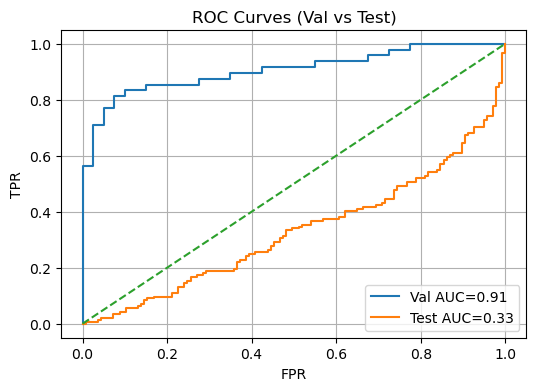

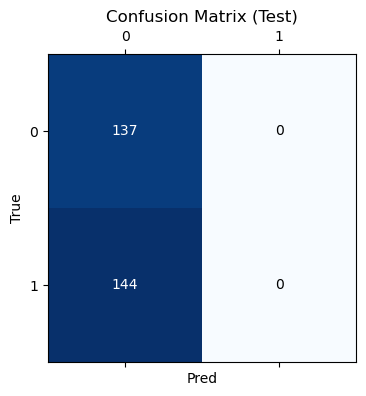

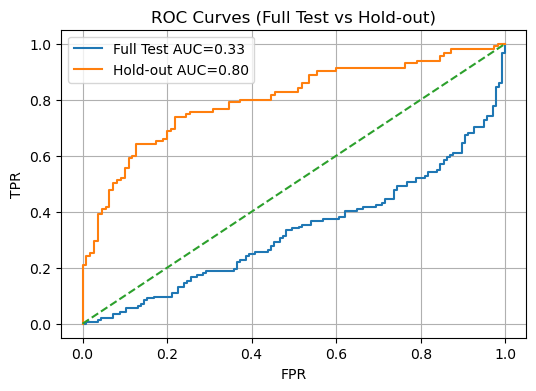

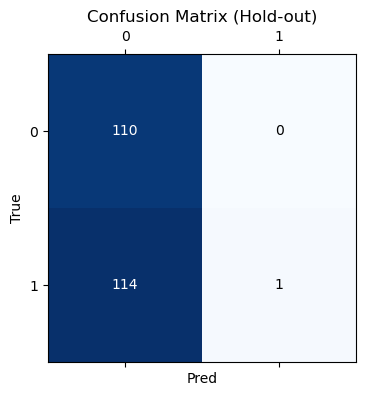

In [ ]:
# Jupyter Notebook용: Test 일부로 재학습(fine-tune) 및 이미지 저장까지 포함한 통합 스크립트
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

# ────────────────────────────────────────────────────────
# 0. 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "mean"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 20
EARLY_STOP      = 5       # fine-tune 조기종료 patience
TEST_FRACTION   = 0.2     # 테스트의 20%를 fine-tune에 사용
SAVE_DIR        = Path("fusion_images")
SAVE_DIR.mkdir(exist_ok=True)
# ────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────
# 1. Embedding & Label 로드 함수
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

# TS / ST train-valid-test 전부 로드
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# ST 차원 평균 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# ────────────────────────────────────────────────────────
# 2. Valid에서 optimal threshold 계산 (간단 LR 이용)
scaler = StandardScaler().fit(np.concatenate([X_ts_tr, X_st_tr], axis=1))
X_va_scaled = scaler.transform(np.concatenate([X_ts_va, X_st_va], axis=1))

lr = LogisticRegression(max_iter=1000).fit(
    scaler.transform(np.concatenate([X_ts_tr, X_st_tr], axis=1)), y_tr
)
probs_va  = lr.predict_proba(X_va_scaled)[:,1]
fpr_va, tpr_va, ths_va = roc_curve(y_va, probs_va)
opt_thr_va = ths_va[np.argmax(tpr_va - fpr_va)]
print(f"Optimal threshold from VALID ROC: {opt_thr_va:.3f}")

# ────────────────────────────────────────────────────────
# 3. Train+Valid 전체로 Head MLP 재학습
X_trva = np.concatenate([
    np.concatenate([X_ts_tr, X_ts_va], axis=0),
    np.concatenate([X_st_tr, X_st_va], axis=0)
], axis=1)
y_trva = np.concatenate([y_tr, y_va], axis=0)

X_trva_scaled = scaler.transform(X_trva).astype(np.float32)
X_te_scaled   = scaler.transform(np.concatenate([X_ts_te, X_st_te], axis=1)).astype(np.float32)

class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

model = HeadMLP(X_trva_scaled.shape[1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss()

ds_trva = TensorDataset(torch.from_numpy(X_trva_scaled), torch.from_numpy(y_trva))
dl_trva = DataLoader(ds_trva, batch_size=BATCH_SIZE, shuffle=True)

best_loss, patience = float('inf'), 0
for epoch in range(1, RETRAIN_EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in dl_trva:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        running += loss.item()*yb.size(0)
    avg = running/len(ds_trva)
    print(f"[Retrain {epoch}/{RETRAIN_EPOCHS}] loss={avg:.4f}")
    if avg < best_loss:
        best_loss, patience = avg, 0
        best_state = model.state_dict()
    else:
        patience += 1
        if patience>=EARLY_STOP:
            print("Early stopping retrain")
            break
model.load_state_dict(best_state)

# ────────────────────────────────────────────────────────
# 4. Test 전체 평가 (FULL TEST threshold & F1 threshold 동시 계산)
model.eval()
with torch.no_grad():
    xb = torch.from_numpy(X_te_scaled).to(DEVICE)
    out = model(xb)
    probs_te = torch.softmax(out,1)[:,1].cpu().numpy()

# 4.1 Full Test ROC threshold (Youden's J)
fpr_te, tpr_te, ths_te = roc_curve(y_te, probs_te)
opt_thr_te = ths_te[np.argmax(tpr_te - fpr_te)]
print(f"Optimal threshold from FULL TEST ROC: {opt_thr_te:.3f}")

# 4.2 F1-score 기준 최적 threshold
ths = np.linspace(0,1,101)
f1s  = [f1_score(y_te, (probs_te>t).astype(int)) for t in ths]
opt_thr_f1 = ths[np.argmax(f1s)]
print(f"Optimal threshold by F1-score: {opt_thr_f1:.3f}")

# 4.3 두 threshold로 각각 예측 & 평가
def eval_with_thr(thr, desc):
    preds = (probs_te > thr).astype(int)
    acc  = accuracy_score(y_te, preds)
    cm   = confusion_matrix(y_te, preds)
    aucv = auc(fpr_te, tpr_te)
    print(f"\n[{desc}] thr={thr:.3f}  Acc={acc:.4f}, AUC(full)={aucv:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Report:\n", classification_report(y_te, preds, digits=4))

eval_with_thr(opt_thr_te, "FullROC")
eval_with_thr(opt_thr_f1, "F1Opt")

# ────────────────────────────────────────────────────────
# 5. Test 일부 가져와 fine-tune 후 나머지 평가 (threshold는 FullROC 기준)
X_te_ft, X_te_hold, y_te_ft, y_te_hold = train_test_split(
    X_te_scaled, y_te, test_size=1-TEST_FRACTION,
    stratify=y_te, random_state=42
)
X_ft_tr = np.vstack([X_trva_scaled, X_te_ft])
y_ft_tr = np.concatenate([y_trva, y_te_ft])

model_ft = HeadMLP(X_ft_tr.shape[1]).to(DEVICE)
opt_ft   = torch.optim.AdamW(model_ft.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
best_loss, patience = float('inf'), 0

ds_ft = TensorDataset(torch.from_numpy(X_ft_tr), torch.from_numpy(y_ft_tr))
dl_ft = DataLoader(ds_ft, batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(1, RETRAIN_EPOCHS+1):
    model_ft.train()
    running = 0.0
    for xb, yb in dl_ft:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_ft.zero_grad()
        out = model_ft(xb)
        loss = crit(out, yb)
        loss.backward(); opt_ft.step()
        running += loss.item()*yb.size(0)
    avg = running/len(ds_ft)
    if avg < best_loss:
        best_loss, patience = avg, 0
        best_state_ft = model_ft.state_dict()
    else:
        patience += 1
        if patience>=EARLY_STOP: break
model_ft.load_state_dict(best_state_ft)

# Evaluate hold-out
model_ft.eval()
with torch.no_grad():
    out = model_ft(torch.from_numpy(X_te_hold).to(DEVICE))
    probs_hold = torch.softmax(out,1)[:,1].cpu().numpy()
preds_hold = (probs_hold > opt_thr_te).astype(int)
acc_h = accuracy_score(y_te_hold, preds_hold)
auc_h = auc(*roc_curve(y_te_hold, probs_hold)[:2])
cm_h  = confusion_matrix(y_te_hold, preds_hold)

print(f"\nHold-out Acc @ thr={opt_thr_te:.3f}: {acc_h:.4f}, AUC={auc_h:.4f}")
print("Hold-out CM:\n", cm_h)

# ────────────────────────────────────────────────────────
# 6. 이미지 저장 (ROC & Confusion Matrix)
# Val vs Test ROC
plt.figure(figsize=(6,4))
plt.plot(fpr_va, tpr_va, label=f"Val AUC={auc(fpr_va,tpr_va):.2f}")
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc(fpr_te,tpr_te):.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Val vs Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_val_test.png")
plt.show()

# Test Confusion Matrix (FullROC thr)
fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(confusion_matrix(y_te, (probs_te>opt_thr_te)), cmap="Blues")
for (i,j),v in np.ndenumerate(cax.get_array()):
    ax.text(j,i,str(v),ha='center',va='center',
            color='white' if v>cax.get_array().max()/2 else 'black')
ax.set_xlabel("Pred"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Test)")
fig.savefig(SAVE_DIR/"confusion_test.png")
plt.show()
plt.close(fig)

# Hold-out Confusion Matrix
fig, ax = plt.subplots(figsize=(4,4))
cax = ax.matshow(cm_h, cmap="Blues")
for (i,j),v in np.ndenumerate(cm_h):
    ax.text(j,i,str(v),ha='center',va='center',
            color='white' if v>cm_h.max()/2 else 'black')
ax.set_xlabel("Pred"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Hold-out)")
fig.savefig(SAVE_DIR/"confusion_holdout.png")
plt.show()
plt.close(fig)
